# Group 9 ISSS609  Project Code

# Sephora Sentiments: Unveiling Insights through Text Analytics

# Loading The Packages

In [20]:
import pandas as pd
import numpy as np
from numpy.random import rand
import re

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.random import rand
from ast import literal_eval
from matplotlib import colormaps
import squarify

from wordcloud import WordCloud
import networkx as nx
import pickle
import string
from collections import Counter, defaultdict
import operator
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import gensim
from gensim import corpora


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


###### run this to get the requirements

## Data pre-processing

In [21]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
import numpy as np
import os

import nltk
from nltk.corpus import PlaintextCorpusReader

In [36]:
import preprocess2
reviews_corpus = preprocess2.load_corpus('sephora_corpus')
reviews_docs = preprocess2.corpus2docs(reviews_corpus)
reviews_docs_joined = [" ".join(x) for x in reviews_docs]  #joined to fit vectorizer

In [3]:
print(reviews_docs[0][:30])

['recieved', 'product', 'free', 'exchange', 'honest', 'review', 'skin', 'cream', 'really', 'great', 'moisturizing', 'creamy', 'doesnt', 'leave', 'skin', 'feeling', 'sticky', 'wish', 'pump', 'stay', 'cleaner', 'thats', 'preference', 'great', 'skin', 'cream', 'high', 'quality']


## LDA with Gensim

### Unigram LDA

In [37]:
# Create a Dictionary
id2word = corpora.Dictionary(reviews_docs)

# Create a Corpus
texts = reviews_docs

# Term Document Frequency
corpus = [id2word.doc2bow(doc) for doc in texts]

# View the first 30 items of the first document in the corpus
print(corpus[0][:30])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 3), (20, 1), (21, 1), (22, 1), (23, 1)]


In [5]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [6]:
from gensim.models import CoherenceModel

def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [7]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.30))]

corpus_title = ['30% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pbar.close()

  0%|          | 0/270 [00:00<?, ?it/s]

100%|██████████| 270/270 [6:05:05<00:00, 81.13s/it]  


In [8]:
pd.DataFrame(model_results).to_csv('./unigram_lda_tuning_results.csv', index=False)

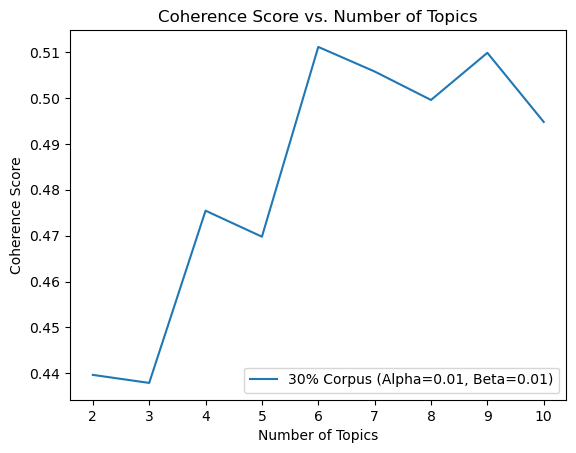

In [9]:
import matplotlib.pyplot as plt

# Extract the data for plotting
topics = model_results['Topics']
coherence_scores = model_results['Coherence']
alpha_values = model_results['Alpha']
beta_values = model_results['Beta']

# Filter the data for alpha = 0.01 and beta = 0.01
filtered_indices = [(alpha == 0.01) and (beta == 0.01) for alpha, beta in zip(alpha_values, beta_values)]

filtered_topics = [topics[i] for i, is_filtered in enumerate(filtered_indices) if is_filtered]
filtered_coherence_scores = [coherence_scores[i] for i, is_filtered in enumerate(filtered_indices) if is_filtered]

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Plot coherence scores for the filtered data
ax.plot(filtered_topics, filtered_coherence_scores, label='30% Corpus (Alpha=0.01, Beta=0.01)')

# Set labels and title
ax.set_xlabel('Number of Topics')
ax.set_ylabel('Coherence Score')
ax.set_title('Coherence Score vs. Number of Topics')

# Display a legend
ax.legend()

# Show the plot
plt.show()


In [10]:
optimal_unigram6_lda = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=6, 
                                       random_state=100,
                                       alpha = 0.61,
                                       eta = 0.9099999999999999,
                                       per_word_topics=True, 
                                       chunksize=100,
                                       passes=10,)


In [11]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()  # Enable notebook mode

# Prepare the data for visualization
optimal_unigram6_lda_display = gensimvis.prepare(optimal_unigram6_lda, corpus, id2word, sort_topics=False)

In [12]:
optimal_unigram6_lda_display

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.182233  0.057520       1        1  10.401223
1      0.130837  0.021768       2        1  14.143511
2     -0.113891 -0.056734       3        1  20.744347
3     -0.042770 -0.205843       4        1  21.343850
4      0.012893  0.013369       5        1  23.792445
5     -0.169303  0.169919       6        1   9.574624, topic_info=          Term          Freq         Total Category  logprob  loglift
1        cream  20454.000000  20454.000000  Default  30.0000  30.0000
141        eye  18651.000000  18651.000000  Default  29.0000  29.0000
19        skin  96744.000000  96744.000000  Default  28.0000  28.0000
86        love  35036.000000  35036.000000  Default  27.0000  27.0000
63        face  22939.000000  22939.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
126        use   1769.511931  25883.842994   Topic6  -4.9936  -0.3369
13     product   1914.389150  66214.421938   Topic6  -4.9149  -1.1974
79         ive   1390.026559  15352.286651   Topic6  -5.2350  -0.0559
16      really   1329.419949  21728.898053   Topic6  -5.2796  -0.4478
109  recommend   1238.915826  12775.894293   Topic6  -5.3501   0.0127

[447 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
793       1  0.079053  absolutely
793       2  0.650239  absolutely
793       3  0.078848  absolutely
793       4  0.040141  absolutely
793       5  0.102605  absolutely
...     ...       ...         ...
135       2  0.002315     younger
135       3  0.025467     younger
135       4  0.002315     younger
135       5  0.016206     younger
135       6  0.949233     younger

[2154 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

In [13]:
import pickle
pickle.dump(optimal_unigram6_lda, open('optimal_unigram6_lda.pkl', 'wb'))

In [27]:
optimal_unigram6_lda = pickle.load(open('optimal_unigram6_lda.pkl', 'rb'))

for idx, topic in optimal_unigram6_lda.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.029*"sunscreen" + 0.026*"lip" + 0.021*"love" + 0.021*"makeup" + 0.016*"glow" + 0.014*"look" + 0.013*"perfect" + 0.013*"spf" + 0.013*"doesnt" + 0.011*"day"


Topic: 1 
Words: 0.049*"skin" + 0.047*"love" + 0.042*"face" + 0.027*"feel" + 0.018*"amazing" + 0.018*"cleanser" + 0.016*"great" + 0.016*"mask" + 0.015*"use" + 0.015*"soft"


Topic: 2 
Words: 0.061*"skin" + 0.025*"product" + 0.023*"using" + 0.019*"ive" + 0.016*"use" + 0.013*"acne" + 0.013*"week" + 0.013*"dry" + 0.011*"day" + 0.011*"sensitive"


Topic: 3 
Words: 0.030*"product" + 0.025*"like" + 0.014*"smell" + 0.014*"dont" + 0.011*"didnt" + 0.010*"would" + 0.010*"price" + 0.010*"good" + 0.010*"get" + 0.010*"really"


Topic: 4 
Words: 0.064*"skin" + 0.041*"product" + 0.023*"feel" + 0.019*"serum" + 0.018*"moisturizer" + 0.016*"received" + 0.014*"great" + 0.014*"really" + 0.011*"like" + 0.011*"nice"


Topic: 5 
Words: 0.075*"cream" + 0.071*"eye" + 0.021*"line" + 0.017*"dark" + 0.017*"fine" + 0.013*"area" + 0.013*"diff

In [38]:
optimal_unigram9_lda = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=9, 
                                       random_state=100,
                                       alpha = 'asymmetric',
                                       eta = 0.31,
                                       per_word_topics=True, 
                                       chunksize=100,
                                       passes=10,)


In [39]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()  # Enable notebook mode

# Prepare the data for visualization
optimal_unigram9_lda_display = gensimvis.prepare(optimal_unigram9_lda, corpus, id2word, sort_topics=False)

In [40]:
optimal_unigram9_lda_display

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.098420 -0.047335       1        1  21.276380
1     -0.086439  0.061865       2        1  13.577212
2     -0.107948  0.051439       3        1  17.856613
3     -0.013642  0.239247       4        1  10.382255
4     -0.136277 -0.006821       5        1  16.443721
5     -0.027259  0.007341       6        1   6.229063
6     -0.067437 -0.206662       7        1   9.970208
7      0.095278 -0.111409       8        1   3.226061
8      0.442144  0.012335       9        1   1.038488, topic_info=          Term           Freq          Total Category  logprob  loglift
141        eye   18362.000000   18362.000000  Default  30.0000  30.0000
19        skin  101317.000000  101317.000000  Default  29.0000  29.0000
1        cream   20381.000000   20381.000000  Default  28.0000  28.0000
150     makeup   11913.000000   11913.000000  Default  27.0000  27.0000
162  sunscreen    8495.000000    8495.000000  Default  26.0000  26.0000
..         ...            ...            ...      ...      ...      ...
117        spf     205.093756    3730.302914   Topic9  -4.9273   1.6666
642    mineral     119.987632     674.729025   Topic9  -5.4633   2.8405
991       safe     101.075219     398.265133   Topic9  -5.6349   3.1962
614     gifted      96.275641    2306.970146   Topic9  -5.6835   1.3909
811       burn      85.491312    1043.900562   Topic9  -5.8023   2.0651

[678 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3710      7  0.977487    abrasive
7771      6  0.968263     absolue
793       1  0.200414  absolutely
793       2  0.252279  absolutely
793       3  0.073590  absolutely
...     ...       ...         ...
861       3  0.124129         yes
861       4  0.018889         yes
861       5  0.000899         yes
861       6  0.026985         yes
861       7  0.000899         yes

[1956 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9])

In [42]:
pyLDAvis.save_html(optimal_unigram9_lda_display, 'optimal_unigram9_lda.html')

In [43]:
import pickle
pickle.dump(optimal_unigram9_lda, open('optimal_unigram9_lda.pkl', 'wb'))

In [44]:
optimal_unigram9_lda = pickle.load(open('optimal_unigram9_lda.pkl', 'rb'))

for idx, topic in optimal_unigram9_lda.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.046*"skin" + 0.022*"love" + 0.020*"feel" + 0.020*"like" + 0.018*"moisturizer" + 0.016*"product" + 0.015*"great" + 0.014*"sunscreen" + 0.013*"lip" + 0.013*"doesnt"


Topic: 1 
Words: 0.024*"product" + 0.024*"face" + 0.020*"love" + 0.017*"use" + 0.012*"one" + 0.011*"like" + 0.011*"time" + 0.011*"little" + 0.011*"way" + 0.010*"skin"


Topic: 2 
Words: 0.052*"skin" + 0.026*"product" + 0.018*"using" + 0.016*"acne" + 0.014*"ive" + 0.013*"use" + 0.010*"week" + 0.010*"dry" + 0.010*"sensitive" + 0.009*"used"


Topic: 3 
Words: 0.029*"product" + 0.021*"like" + 0.017*"smell" + 0.011*"packaging" + 0.010*"price" + 0.010*"dont" + 0.010*"didnt" + 0.009*"get" + 0.009*"would" + 0.008*"bottle"


Topic: 4 
Words: 0.048*"product" + 0.042*"skin" + 0.024*"received" + 0.021*"serum" + 0.017*"using" + 0.016*"feel" + 0.014*"review" + 0.014*"free" + 0.012*"sample" + 0.012*"honest"


Topic: 5 
Words: 0.105*"eye" + 0.066*"cream" + 0.025*"line" + 0.018*"fine" + 0.015*"dark" + 0.015*"area" + 0.013

### Bigram LDA

In [45]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(reviews_docs, min_count=5, threshold=100) # higher threshold fewer phrases. 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [46]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [47]:
data_words_bigrams = make_bigrams(reviews_docs)

In [32]:
print(data_words_bigrams[:1][0][:30])

['recieved', 'product', 'free', 'exchange_honest', 'review', 'skin', 'cream', 'really', 'great', 'moisturizing', 'creamy', 'doesnt', 'leave', 'skin', 'feeling', 'sticky', 'wish', 'pump', 'stay', 'cleaner', 'thats', 'preference', 'great', 'skin', 'cream', 'high', 'quality']


In [48]:
# Create a Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create a Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(doc) for doc in texts]

# View the first 30 items of the first document in the corpus
print(corpus[0][:30])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 3), (19, 1), (20, 1), (21, 1), (22, 1)]


In [39]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.30))]

corpus_title = ['30% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pbar.close()

100%|██████████| 270/270 [5:33:16<00:00, 74.06s/it]  


In [40]:
pd.DataFrame(model_results).to_csv('./bigram_lda_tuning_results.csv', index=False)

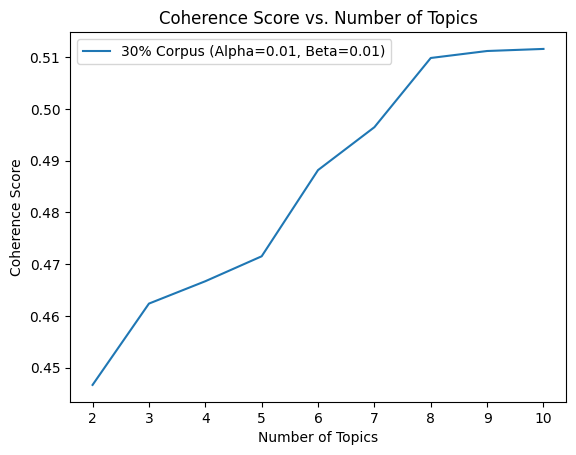

In [41]:
import matplotlib.pyplot as plt

# Extract the data for plotting
topics = model_results['Topics']
coherence_scores = model_results['Coherence']
alpha_values = model_results['Alpha']
beta_values = model_results['Beta']

# Filter the data for alpha = 0.01 and beta = 0.01
filtered_indices = [(alpha == 0.01) and (beta == 0.01) for alpha, beta in zip(alpha_values, beta_values)]

filtered_topics = [topics[i] for i, is_filtered in enumerate(filtered_indices) if is_filtered]
filtered_coherence_scores = [coherence_scores[i] for i, is_filtered in enumerate(filtered_indices) if is_filtered]

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Plot coherence scores for the filtered data
ax.plot(filtered_topics, filtered_coherence_scores, label='30% Corpus (Alpha=0.01, Beta=0.01)')

# Set labels and title
ax.set_xlabel('Number of Topics')
ax.set_ylabel('Coherence Score')
ax.set_title('Coherence Score vs. Number of Topics')

# Display a legend
ax.legend()

# Show the plot
plt.show()


In [51]:
optimal_bigram6_lda = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=6, 
                                       random_state=100,
                                       alpha = 0.31,
                                       eta = 0.9099999999999999,
                                       per_word_topics=True, 
                                       chunksize=100,
                                       passes=10,)


In [52]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()  # Enable notebook mode

# Prepare the data for visualization
optimal_bigram6_lda_display = gensimvis.prepare(optimal_bigram6_lda, corpus, id2word, sort_topics=False)

In [53]:
optimal_bigram6_lda_display

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.078452 -0.122930       1        1  19.480812
1     -0.197831  0.039338       2        1   8.243847
2      0.109175  0.155936       3        1   8.661444
3      0.008324  0.036956       4        1  24.426325
4      0.165324 -0.115838       5        1   8.959399
5     -0.006540  0.006537       6        1  30.228173, topic_info=         Term          Freq         Total Category  logprob  loglift
137       eye  17567.000000  17567.000000  Default  30.0000  30.0000
18       skin  97477.000000  97477.000000  Default  29.0000  29.0000
1       cream  19252.000000  19252.000000  Default  28.0000  28.0000
210     serum  14497.000000  14497.000000  Default  27.0000  27.0000
153  received  10343.000000  10343.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
121       use   8391.729368  25923.427376   Topic6  -4.5693   0.0685
54        day   6001.356270  14289.130225   Topic6  -4.9046   0.3289
125      well   5468.871721  11908.011359   Topic6  -4.9975   0.4183
122     using   6317.931909  23040.040402   Topic6  -4.8532  -0.0974
109     smell   5593.075953  15109.169310   Topic6  -4.9751   0.2026

[447 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
929       1  0.049389  absorbed
929       2  0.000760  absorbed
929       3  0.004559  absorbed
929       4  0.000760  absorbed
929       5  0.531126  absorbed
...     ...       ...       ...
131       2  0.002455   younger
131       3  0.854395   younger
131       4  0.117848   younger
131       5  0.007365   younger
131       6  0.014731   younger

[2112 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

In [56]:
import pickle
pickle.dump(optimal_bigram6_lda, open('optimal_bigram6_lda.pkl', 'wb'))

In [34]:
optimal_bigram6_lda = pickle.load(open('optimal_bigram6_lda.pkl', 'rb'))

for idx, topic in optimal_bigram6_lda.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.026*"product" + 0.026*"like" + 0.016*"smell" + 0.016*"sunscreen" + 0.011*"dont" + 0.010*"good" + 0.010*"really" + 0.009*"would" + 0.009*"didnt" + 0.008*"price"


Topic: 1 
Words: 0.032*"lip" + 0.027*"mask" + 0.025*"cleanser" + 0.019*"makeup" + 0.019*"balm" + 0.013*"face" + 0.012*"use" + 0.010*"love" + 0.010*"clean" + 0.009*"cleansing"


Topic: 2 
Words: 0.076*"eye" + 0.049*"cream" + 0.022*"line" + 0.017*"fine" + 0.015*"using" + 0.014*"difference" + 0.014*"product" + 0.011*"area" + 0.011*"week" + 0.010*"noticed"


Topic: 3 
Words: 0.044*"skin" + 0.028*"product" + 0.018*"using" + 0.015*"use" + 0.014*"ive" + 0.012*"acne" + 0.011*"week" + 0.010*"used" + 0.009*"face" + 0.008*"day"


Topic: 4 
Words: 0.043*"received" + 0.040*"serum" + 0.039*"product" + 0.026*"free" + 0.026*"sample" + 0.024*"review" + 0.021*"influenster" + 0.014*"skin" + 0.012*"exchange_honest" + 0.011*"complimentary"


Topic: 5 
Words: 0.080*"skin" + 0.032*"love" + 0.028*"feel" + 0.026*"product" + 0.017*"g

In [59]:
optimal_bigram8_lda = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=8, 
                                       random_state=100,
                                       alpha = 'asymmetric',
                                       eta = 0.31,
                                       per_word_topics=True, 
                                       chunksize=100,
                                       passes=10,)


In [60]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()  # Enable notebook mode

# Prepare the data for visualization
optimal_bigram8_lda_display = gensimvis.prepare(optimal_bigram8_lda, corpus, id2word, sort_topics=False)

In [61]:
optimal_bigram8_lda_display

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.056640 -0.091549       1        1  16.571251
1     -0.063006 -0.190839       2        1   6.210171
2      0.055061  0.154494       3        1   8.851867
3      0.082734  0.017476       4        1  21.602371
4      0.135161  0.062841       5        1  12.610601
5      0.012008 -0.073432       6        1  10.296648
6     -0.351969  0.078247       7        1   2.620118
7      0.073370  0.042762       8        1  21.236974, topic_info=         Term           Freq          Total Category  logprob  loglift
137       eye   18624.000000   18624.000000  Default  30.0000  30.0000
18       skin  101412.000000  101412.000000  Default  29.0000  29.0000
1       cream   20622.000000   20622.000000  Default  28.0000  28.0000
410       lip    7285.000000    7285.000000  Default  27.0000  27.0000
153  received   11113.000000   11113.000000  Default  26.0000  26.0000
..        ...            ...            ...      ...      ...      ...
122     using    5110.560841   24010.585879   Topic8  -4.7122   0.0022
121       use    5187.276557   27106.628813   Topic8  -4.6973  -0.1041
3      doesnt    3885.451944   11486.844656   Topic8  -4.9863   0.4655
81       look    3856.732354   11694.542343   Topic8  -4.9937   0.4401
190      good    3869.698245   15373.956512   Topic8  -4.9904   0.1699

[624 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
784       1  0.093089       absolutely
784       2  0.008659       absolutely
784       3  0.061010       absolutely
784       4  0.136190       absolutely
784       5  0.000984       absolutely
...     ...       ...              ...
2238      1  0.009246            yummy
2238      2  0.064720            yummy
2238      7  0.915324            yummy
7964      8  0.951005  zenovia_peptide
3955      4  0.984209              zit

[1736 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

In [62]:
pickle.dump(optimal_bigram8_lda, open('optimal_bigram8_lda.pkl', 'wb'))

In [35]:
optimal_bigram8_lda = pickle.load(open('optimal_bigram8_lda.pkl', 'rb'))

for idx, topic in optimal_bigram8_lda.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.031*"product" + 0.027*"like" + 0.018*"smell" + 0.012*"dont" + 0.011*"really" + 0.010*"good" + 0.010*"price" + 0.009*"would" + 0.009*"one" + 0.009*"get"


Topic: 1 
Words: 0.043*"cleanser" + 0.029*"makeup" + 0.029*"face" + 0.019*"use" + 0.019*"clean" + 0.013*"cleansing" + 0.012*"wash" + 0.012*"balm" + 0.011*"remove" + 0.010*"gentle"


Topic: 2 
Words: 0.078*"eye" + 0.047*"cream" + 0.022*"line" + 0.017*"product" + 0.016*"using" + 0.015*"fine" + 0.013*"difference" + 0.011*"love" + 0.011*"area" + 0.011*"week"


Topic: 3 
Words: 0.052*"skin" + 0.028*"product" + 0.019*"using" + 0.015*"use" + 0.014*"ive" + 0.013*"acne" + 0.011*"week" + 0.009*"used" + 0.009*"day" + 0.009*"sensitive"


Topic: 4 
Words: 0.045*"product" + 0.033*"skin" + 0.033*"received" + 0.020*"free" + 0.020*"sample" + 0.019*"serum" + 0.018*"review" + 0.016*"influenster" + 0.011*"like" + 0.011*"really"


Topic: 5 
Words: 0.034*"skin" + 0.030*"sunscreen" + 0.023*"makeup" + 0.016*"love" + 0.013*"spf" + 0.012*"pr